In [1]:
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras_balanced_batch_generator import make_generator

pd.set_option("display.precision", 2)
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import random
import math
from numpy.linalg import inv

from imblearn.over_sampling import RandomOverSampler
from helpers import ordinal_to_label, digitize, plot_confusion_matrix, plot_model_history, label_to_one_hot_like, one_hot_like_to_label, plot_cm_matrix

In [2]:
np.set_printoptions(precision=2)
plt.rcParams["figure.figsize"] = (10, 10)

### load data

In [3]:
df = pd.read_pickle("./all_session.pkl")
df.head()

combined_eye_closure  left_image_eye_closure  \
filename frame                                                 
001_1_a  0                      0.26                    0.25   
         1                      0.27                    0.22   
         2                      0.27                    0.23   
         3                      0.27                    0.22   
         4                      0.26                    0.22   

                right_image_eye_closure  combined_eye_state  \
filename frame                                                
001_1_a  0                         0.28                   0   
         1                         0.31                   0   
         2                         0.32                   0   
         3                         0.32                   0   
         4                         0.31                   0   

                left_image_eye_state  right_image_eye_state  subject_id  \
filename frame                                                            
001_1_a  0                         0                      0           1   
         1                         0                      0           1   
         2                         0                      0           1   
         3                         0                      0           1   
         4                         0                      0           1   

                session_id  session_type  num_blinks  mean_blink_length  \
filename frame                                                            
001_1_a  0               1             0           0                0.0   
         1               1             0           0                0.0   
         2               1             0           0                0.0   
         3               1             0           0                0.0   
         4               1             0           0                0.0   

                mean_opening_velocity  mean_closing_velocity  \
filename frame                                                 
001_1_a  0                        0.0                    0.0   
         1                        0.0                    0.0   
         2                        0.0                    0.0   
         3                        0.0                    0.0   
         4                        0.0                    0.0   

                karolinska_response_nearest_interpolation  \
filename frame                                              
001_1_a  0                                              6   
         1                                              6   
         2                                              6   
         3                                              6   
         4                                              6   

                karolinska_response_linear_interpolation  
filename frame                                            
001_1_a  0                                             6  
         1                                             6  
         2                                             6  
         3                                             6  
         4                                             6

In [4]:
# columns
print(df.columns)

Index(['combined_eye_closure', 'left_image_eye_closure',
       'right_image_eye_closure', 'combined_eye_state', 'left_image_eye_state',
       'right_image_eye_state', 'subject_id', 'session_id', 'session_type',
       'num_blinks', 'mean_blink_length', 'mean_opening_velocity',
       'mean_closing_velocity', 'karolinska_response_nearest_interpolation',
       'karolinska_response_linear_interpolation'],
      dtype='object')


### train and test split

In [5]:
# filter out alcohol sessions
unique_indices = list(
    filter(lambda x: not "a" in x,
           df.index.get_level_values('filename').unique()))
subjects = list(set([filename.split("_")[0] for filename in unique_indices]))
random.shuffle(subjects)

test_size = .2
split_index = math.ceil(test_size * len(subjects))
test_subjects = subjects[:split_index]
train_subjects = subjects[split_index:]
val_subjects = train_subjects[:2]
train_subjects = train_subjects[2:]
print(test_subjects, train_subjects, val_subjects)


['009', '002'] ['001', '003', '011', '005', '008'] ['004', '014']


In [30]:
train_subjects = ["001", "002", "003", "004", "009"]
val_subjects = ["005", "008"]
test_subjecst = ["011", "014"]

In [31]:
# create boolean index mask
test_subject_mask = df.index.to_frame().filename.str.contains(
    "|".join(test_subjects))
train_subject_mask = df.index.to_frame().filename.str.contains(
    "|".join(train_subjects))
val_subject_mask = df.index.to_frame().filename.str.contains(
    "|".join(val_subjects))

In [32]:
test_df = df[test_subject_mask]
test_df = test_df.copy()
test_df = test_df[test_df["session_type"] != 0]
test_df = test_df.dropna()
#test_df = test_df.sample(frac=1)
# print(len(test_df))

train_df = df[train_subject_mask]
train_df = train_df.copy()
train_df = train_df[train_df["session_type"] != 0]
train_df = train_df.dropna()
#treain_df = train_df.sample(frac=1)
#print(len(train_df))

val_df = df[val_subject_mask]
val_df = val_df.copy()
val_df = val_df[val_df["session_type"] != 0]
val_df = val_df.dropna()
#treain_df = train_df.sample(frac=1)
#print(len(train_df))

feature_columns = [
    'num_blinks', 'mean_blink_length', 'mean_opening_velocity',
    'mean_closing_velocity'
]
target_columns = ["karolinska_response_linear_interpolation"]

X_train = train_df[feature_columns].astype(float).to_numpy()
X_test = test_df[feature_columns].astype(float).to_numpy()
X_val = val_df[feature_columns].astype(float).to_numpy()

y_train = train_df[target_columns].astype(float).to_numpy()
y_test = test_df[target_columns].astype(float).to_numpy()
y_val = val_df[target_columns].astype(float).to_numpy()

print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (1336295, 4)
X_test.shape = (440478, 4)
y_train.shape = (1336295, 1)
y_test.shape = (440478, 1)


In [33]:
# set labels to [0, 8]
y_train = y_train - 1
y_test = y_test - 1
y_val = y_val - 1

In [34]:
# normalize
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train = norm_layer(X_train)
X_test = norm_layer(X_test)
X_val = norm_layer(X_val)

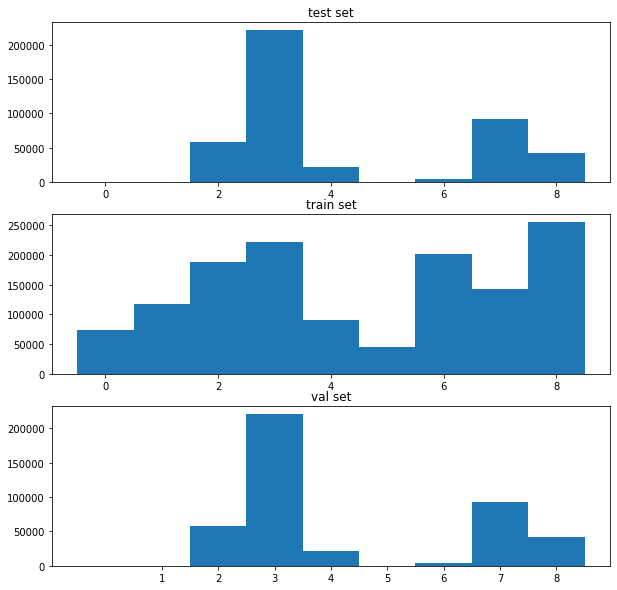

In [35]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
bins = [x - .5 for x in range(0, 10)]
ax1.hist(y_test, bins=bins)
ax1.set_title("test set")
ax2.hist(y_train, bins=bins)
ax2.set_title("train set")
ax3.hist(y_test, bins=bins)
ax3.set_title("val set")

plt.xticks(range(1, 9))
plt.show()

In [36]:
BATCH_SIZE = 256

# create data generator yielding balanced batches
y_train_categorical = keras.utils.to_categorical(y_train)
# data_generator = make_generator(X_train.numpy(), y_train_categorical, batch_size=BATCH_SIZE, categorical=False)

In [37]:
oversample = RandomOverSampler()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
y_train_over = np.expand_dims(y_train_over, 1)

original: (1336295, 4), (1336295, 1)
oversampled : (2299680, 4), (2299680, 1)


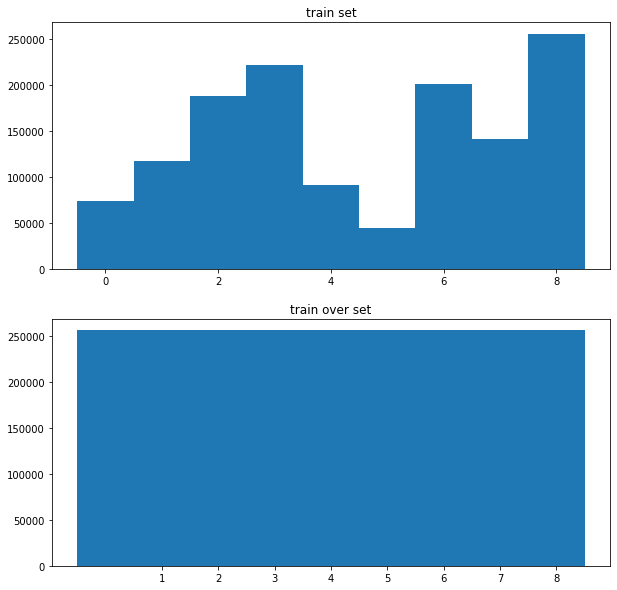

In [38]:
print(f"original: {X_train.shape}, {y_train.shape}")
f, (ax1, ax2) = plt.subplots(2, 1)
bins = [x - .5 for x in range(0, 10)]
ax1.hist(y_train, bins=bins)
ax1.set_title("train set")
print(f"oversampled : {X_train_over.shape}, {y_train_over.shape}")

ax2.hist(y_train_over, bins=bins)
ax2.set_title("train over set")

plt.xticks(range(1, 9))
plt.show()

In [39]:
def casted_accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(tf.add(y_pred, 0.5), tf.int32)
    return tf.divide(
        tf.reduce_sum(tf.cast(tf.equal(y_pred, y_true), tf.int32)),
        tf.size(y_true))


EPOCHS = 5
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
loss = "mae"
optimizer = "sgd"
#optimizer = tf.keras.optimizers.Adam()

regression_model = Sequential()
regression_model.add(Dense(1, input_dim=X_train.shape[-1]))
regression_model.compile(loss=loss,
                         optimizer=optimizer,
                         metrics=[casted_accuracy, "mae"])
regression_model.summary()
with tf.device("cpu:0"):
    regression_history = regression_model.fit(X_train_over, y_train_over,
                                              epochs=EPOCHS,
                                              batch_size=BATCH_SIZE,
                                              validation_data=(X_val, y_val),
                                              callbacks=[callback],
                                              steps_per_epoch=(len(y_train) / BATCH_SIZE)*2)
    
    results = regression_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
    print("test loss, test acc:", results)
model_name = f"./models/regression_model_{loss}_{optimizer}_{BATCH_SIZE}_{EPOCHS}_{int(results[-1] * 100)}"
print(model_name)
regression_model.save(
    model_name
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
10439/10439 [==============================] - 7s 617us/step - loss: 2.3899 - casted_accuracy: 0.1221 - mae: 2.3899 - val_loss: 2.4029 - val_casted_accuracy: 0.0110 - val_mae: 2.4029
Epoch 2/5
10439/10439 [==============================] - 6s 590us/step - loss: 2.1875 - casted_accuracy: 0.1193 - mae: 2.1875 - val_loss: 2.4088 - val_casted_accuracy: 0.0096 - val_mae: 2.4088
Epoch 3/5
10439/10439 [==============================] - 8s 798us/step - loss: 2.1886 - casted_accuracy: 0.1186 - mae: 2.1886 - val_loss: 2.3977 - val_casted_accuracy: 0.0112 - val_mae: 2.3977
Epoch 4/5
10439/10439 [==============================] - 8s 768us/step - lo

keras unbalanced batch generator, 5 epochs, sgd, mae
* test loss, test acc: [2.565487861633301, 0.09800824522972107, 2.565487861633301]  
learn imbalanced, 5 epochs, sgd, mae, minority oversampling
* test loss, test acc: [2.3827099800109863, 0.10097184032201767, 2.3827099800109863]  
learn imbalanced, 5 epochs, sgd, mae, default oversampling  
* test loss, test acc: [2.559556722640991, 0.09821943938732147, 2.559556722640991]


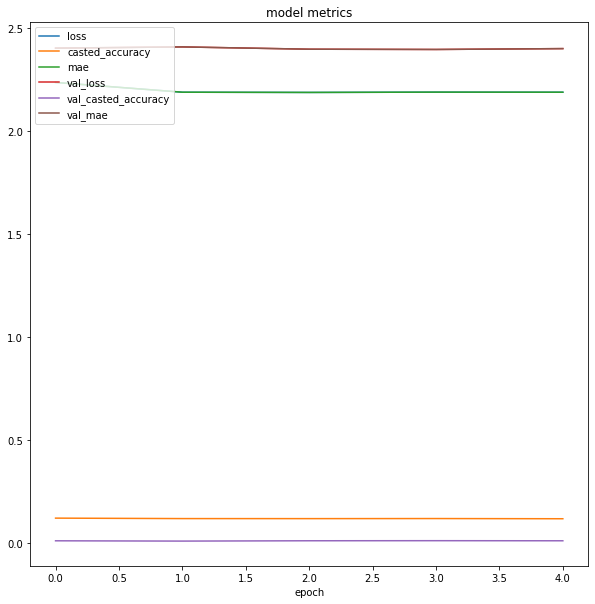

In [40]:
plot_model_history(regression_history)

In [41]:
for name, weigth in zip(feature_columns, regression_model.weights[0].numpy()):
    print(name, weigth)

print("bias", regression_model.weights[1].numpy())

num_blinks [0.65]
mean_blink_length [0.29]
mean_opening_velocity [-0.16]
mean_closing_velocity [0.18]
bias [4.08]


In [42]:
print(f"Test MAE: {results[0]}")
print(f"Test Accuracy {results[1]}")

Test MAE: 1.7905734777450562
Test Accuracy 0.14129935204982758


Confusion matrix, without normalization


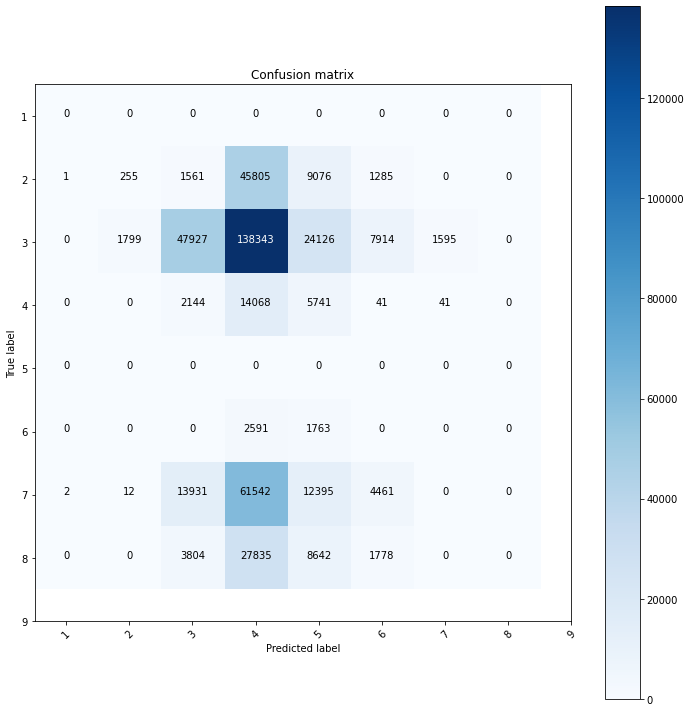

In [43]:
plot_cm_matrix(regression_model, X_test, y_test, output_kind="digitize")

### closed form solution
$$
\beta = (X X^T)^{-1} X^T y
$$

In [44]:
def closed_form_ols(X, y):
    # calculate coefficients using closed-form solution
    coeffs = inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)
    return coeffs


In [45]:
# original dataset no bias
coeffs = closed_form_ols(X_train.numpy(), y_train)
print(coeffs)
for name, weigth in zip(feature_columns, coeffs):
    print(name, weigth[0])

[[ 0.54]
 [ 0.25]
 [-0.31]
 [ 0.19]]
num_blinks 0.542881919228816
mean_blink_length 0.2546260718631034
mean_opening_velocity -0.30945487121410475
mean_closing_velocity 0.18711760620240306


In [46]:
#original dataset with bias feature
bias_ones = np.ones(shape=(len(X_train)))
X_train_with_bias = np.c_[ X_train.numpy(), bias_ones]

coeffs_with_bias = closed_form_ols(X_train_with_bias, y_train)
print(coeffs_with_bias)
for name, weigth in zip(feature_columns + ["bias"], coeffs_with_bias):
    print(name, weigth[0])


[[ 0.54]
 [ 0.25]
 [-0.31]
 [ 0.19]
 [ 4.48]]
num_blinks 0.5428808754694787
mean_blink_length 0.25462532481566713
mean_opening_velocity -0.3094545730273751
mean_closing_velocity 0.18711822610521048
bias 4.484595113206529


In [47]:
# oversampled data without bias feature
coeffs = closed_form_ols(X_train_over, y_train_over)
for name, weigth in zip(feature_columns, coeffs):
    print(name, weigth)

num_blinks [0.09]
mean_blink_length [0.18]
mean_opening_velocity [-0.17]
mean_closing_velocity [-0.]


In [48]:
# oversampled data with bias feature
bias_over_ones = np.ones(shape=(len(X_train_over)))
X_train_over_with_bias = np.c_[ X_train_over, bias_over_ones]
coeffs_over_with_bias = closed_form_ols(X_train_over_with_bias, y_train_over)
print(coeffs_over_with_bias)
for name, weigth in zip(feature_columns + ["bias"], coeffs_over_with_bias):
    print(name, weigth[0])

[[ 0.45]
 [ 0.08]
 [-0.29]
 [ 0.45]
 [ 4.07]]
num_blinks 0.4506882579183497
mean_blink_length 0.07602234670514206
mean_opening_velocity -0.2894829730247614
mean_closing_velocity 0.4505760953548977
bias 4.074387726258293


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
1721/1721 [==============================] - 1s 630us/step - loss: 1.9355 - casted_accuracy: 0.0756 - mae: 1.9355
test loss, test acc: [1.8157179355621338, 0.12538163363933563, 1.8157179355621338]
./models/regression_model_mae_sgd_256_5_181
INFO:tensorflow:Assets written to: ./models/regression_model_mae_sgd_256_5_181/assets
Confusion matrix, without normalization


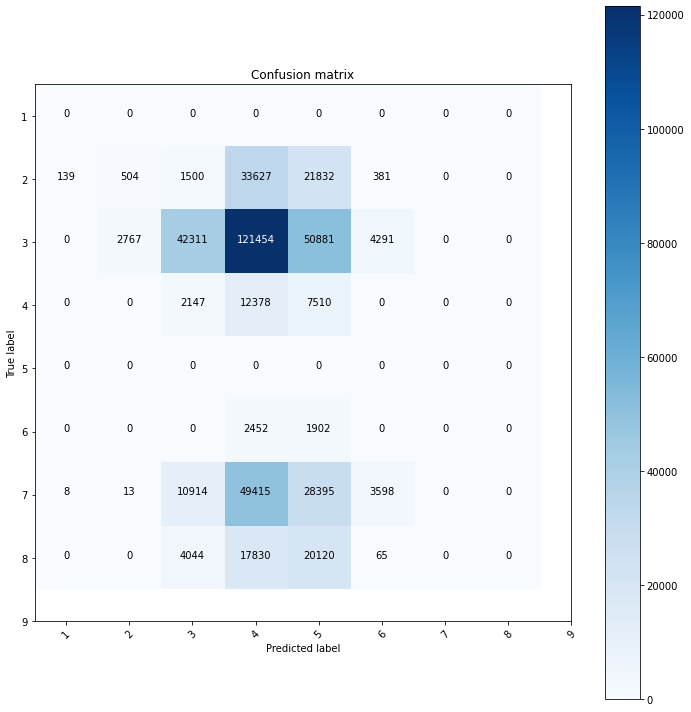

In [49]:
# create model from ols weights

EPOCHS = 5
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
loss = "mae"
optimizer = "sgd"
#optimizer = tf.keras.optimizers.Adam()

closed_form_model = Sequential()
closed_form_model.add(Dense(1, input_dim=X_train.shape[-1]))
closed_form_model.compile(loss=loss,
                         optimizer=optimizer,
                         metrics=[casted_accuracy, "mae"])
closed_form_model.summary()

# set weights
closed_form_model.set_weights([coeffs_over_with_bias[:-1], coeffs_over_with_bias[-1]])

# evaluate and save model
results = closed_form_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)
model_name = f"./models/regression_model_{loss}_{optimizer}_{BATCH_SIZE}_{EPOCHS}_{int(results[-1] * 100)}"
print(model_name)
closed_form_model.save(
    model_name
)


# plot confusion matrix
plot_cm_matrix(closed_form_model, X_test, y_test, output_kind="digitize")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
1721/1721 [==============================] - 1s 633us/step - loss: 1.9633 - casted_accuracy: 0.0163 - mae: 1.9633
test loss, test acc: [1.9218543767929077, 0.03220125660300255, 1.9218543767929077]
./models/regression_model_mae_sgd_256_5_192
INFO:tensorflow:Assets written to: ./models/regression_model_mae_sgd_256_5_192/assets
Confusion matrix, without normalization


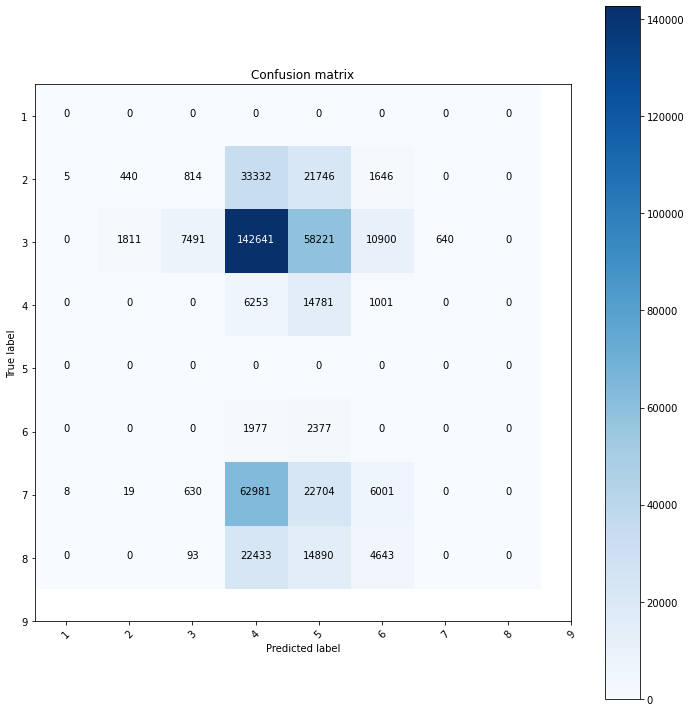

In [50]:
# create model from ols weights

EPOCHS = 5
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
loss = "mae"
optimizer = "sgd"
#optimizer = tf.keras.optimizers.Adam()

closed_form_model = Sequential()
closed_form_model.add(Dense(1, input_dim=X_train.shape[-1]))
closed_form_model.compile(loss=loss,
                         optimizer=optimizer,
                         metrics=[casted_accuracy, "mae"])
closed_form_model.summary()

# set weights
closed_form_model.set_weights([coeffs_with_bias[:-1], coeffs_with_bias[-1]])

# evaluate and save model
results = closed_form_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)
model_name = f"./models/regression_model_{loss}_{optimizer}_{BATCH_SIZE}_{EPOCHS}_{int(results[-1] * 100)}"
print(model_name)
closed_form_model.save(
    model_name
)


# plot confusion matrix
plot_cm_matrix(closed_form_model, X_test, y_test, output_kind="digitize")

[1 1 1]
Confusion matrix, without normalization


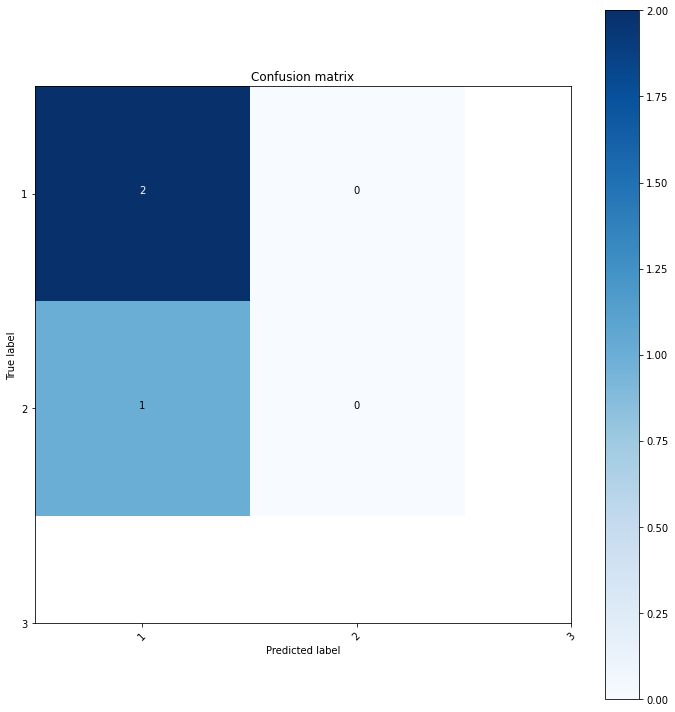

In [57]:
from sklearn.metrics import confusion_matrix


y_test = np.array([1,2,1])
y_pred = np.array([1,0,1])

y_pred = np.clip(y_pred,1,2)
print(y_pred)
c_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(c_matrix,
                          classes=list("123"),
                          normalize=False)